In [15]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

In [16]:

def generate_zmkp_data(num_items, num_objectives=2, num_constraints=2):
    P = np.empty((num_objectives, num_items))
    
    # Generate random integers for each objective with different scales
    for i in range(num_objectives):
        if i == 0:
            P[i] = np.random.randint(1, 100, size=num_items)
        else:
            P[i] = np.random.randint(-100-25*i, -1+25*i, size=num_items)

    W = np.random.randint(1, 50, size=(num_constraints, num_items))
    c = np.random.randint(num_items*2, num_items * 10, size=num_constraints)
    return P, W, c

def solve_weighted_sum(P, W, c, weights):
    num_items = P.shape[1]
    num_objectives = P.shape[0]
    num_constraints = W.shape[0]
    
    model = gp.Model("weighted_sum")
    model.setParam('OutputFlag', 0)  # Suppress Gurobi output
    
    # Variables
    x = model.addVars(num_items, vtype=GRB.BINARY, name="x")
    
    # Objective
    weighted_sum = gp.quicksum(weights[i] * gp.quicksum(P[i,j] * x[j] for j in range(num_items)) for i in range(num_objectives))
    model.setObjective(weighted_sum, GRB.MAXIMIZE)
    
    # Constraints
    for i in range(num_constraints):
        model.addConstr(gp.quicksum(W[i,j] * x[j] for j in range(num_items)) <= c[i], name=f"c{i}")
    
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        solution = model.getAttr('x', x)
        return model.ObjVal, solution
    else:
        return None, None

def solve_individual_objective(P, W, c, obj_index):
    num_items = P.shape[1]
    num_constraints = W.shape[0]
    
    model = gp.Model(f"objective_{obj_index}")
    model.setParam('OutputFlag', 0)  # Suppress Gurobi output
    
    # Variables
    x = model.addVars(num_items, vtype=GRB.BINARY, name="x")
    
    # Objective
    model.setObjective(gp.quicksum(P[obj_index, j] * x[j] for j in range(num_items)), GRB.MAXIMIZE)
    
    # Constraints
    for i in range(num_constraints):
        model.addConstr(gp.quicksum(W[i, j] * x[j] for j in range(num_items)) <= c[i], name=f"c{i}")
    
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return model.ObjVal
    else:
        return None

def solve_tchebycheff(P, W, c, ideal_points):
    num_items = P.shape[1]
    num_objectives = P.shape[0]
    num_constraints = W.shape[0]
    
    model = gp.Model("tchebycheff")
    model.setParam('OutputFlag', 0)  # Suppress Gurobi output
    
    # Variables
    x = model.addVars(num_items, vtype=GRB.BINARY, name="x")
    
    # Objective
    tchebycheff = model.addVar(name="tchebycheff")
    model.setObjective(tchebycheff, GRB.MINIMIZE)
    
    # Constraints
    for i in range(num_constraints):
        model.addConstr(gp.quicksum(W[i,j] * x[j] for j in range(num_items)) <= c[i], name=f"c{i}")
    
    for i in range(num_objectives):
        model.addConstr(tchebycheff >= (ideal_points[i] - gp.quicksum(P[i,j] * x[j] for j in range(num_items))), name=f"tc{i}")
    
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        solution = model.getAttr('x', x)
        return model.ObjVal, solution
    else:
        return None





In [17]:

import collections


def sum_tuples(tuple1, tuple2):
    return tuple(a + b for a, b in zip(tuple1, tuple2))

def is_dominated(candidate, others):
    for other in others:
        if all(o >= c for o, c in zip(other, candidate)):
            return True
    return False
    
def find_vmax(P, item, G, c1, c2, W):
    # find vertical max. considering both objectives 
    num_objectives, num_items = P.shape
    temp_set = set()
    k = 1 
    
    while c1 - k * W[0, item] >= 0 and c2 - k * W[1, item] >= 0:
        if (item + 1, c1 - k * W[0, item], c2 - k * W[1, item]) in G:
            for obj_vector in G[item + 1, c1 - k * W[0, item], c2 - k * W[1, item]]:
                candidate_G = sum_tuples(tuple(k * P[:, item]), obj_vector)
                temp_set.add(candidate_G)
        else:
            temp_set.add(tuple(k * P[:, item]))
        k += 1

    # Include the option of not selecting the item
    if item < num_items -1 :
        temp_set.update(G[item + 1, c1, c2])
    
    # Filter non-dominated solutions
    G_set = set()
    for candidate in temp_set:
        if not is_dominated(candidate, G_set):
            G_set.add(candidate)

    return G_set
def MCKP_DP(P, W, c):
    num_objectives, num_items = P.shape

    # G_j(c1,c2) : max. benefit that can be taken from resources c1 and c2 if the resource allocated to X_j to X_n
    # n : number of items 
    G = collections.defaultdict(set)
    G[num_items-1,0,0].add((0,0))
    
    for item in range(num_items-1, -1, -1): 
        for c1 in range(c[0]+1):
            for c2 in range(c[1]+1):
                if c1 >= W[0, item] and c2 >= W[1, item]:
                    
                    G[item, c1, c2] = find_vmax(P, item, G, c1, c2, W)
                else:
                    if item < num_items-1 :
                        G[item, c1, c2] = G[item+1, c1, c2]
                    else:
                        G[item, c1, c2] .add((0,0))
                
                final_control_set = G[item, c1, c2].copy()
                for candidate in final_control_set:
                    if is_dominated(candidate, final_control_set -{candidate}):
                        G[item, c1, c2].remove(candidate)

    

    return  G[0,c[0],c[1]]


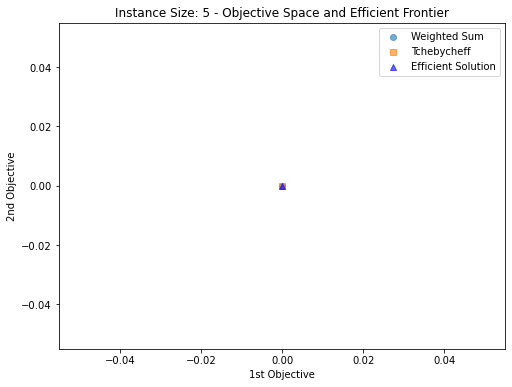

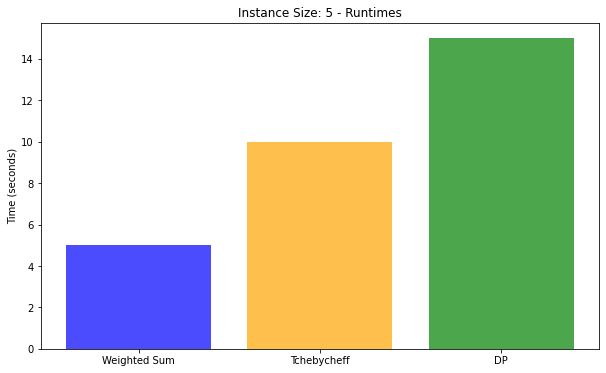

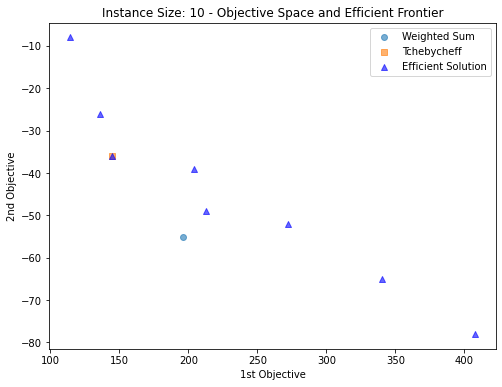

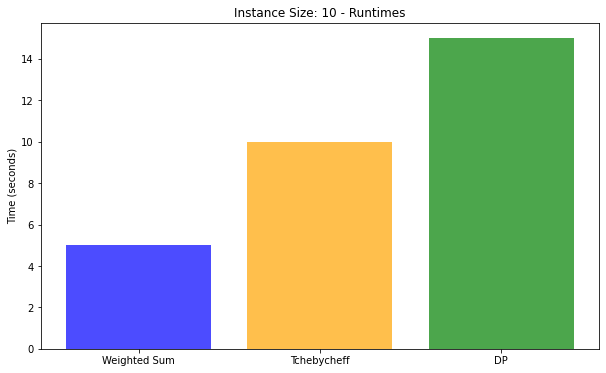

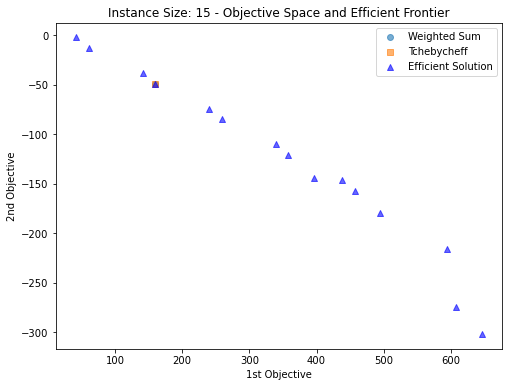

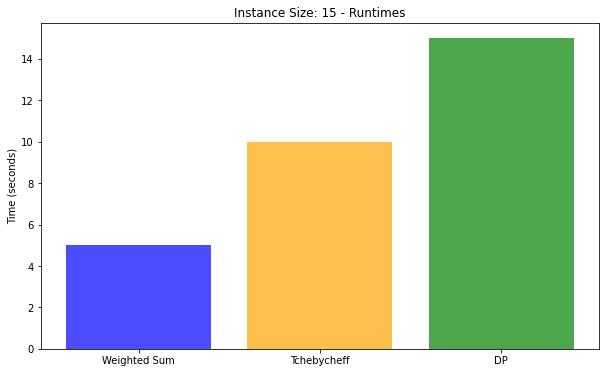

In [18]:

# Parameters
import time


instance_sizes = [5, 10, 15]
weights = np.ones(2) / 2  # Equal weights 

objs = {size: {'weighted_sum': [], 'tchebycheff': []} for size in instance_sizes}
opt_values = {size: {'weighted_sum': [], 'tchebycheff': []} for size in instance_sizes}
ws_obj_values_ = {size: [] for size in instance_sizes}
tc_obj_values_ = {size: [] for size in instance_sizes}
dp_obj_values_ = {size: [] for size in instance_sizes}


runtimes = {size: {'weighted_sum': [], 'tchebycheff': [], 'dp': []} for size in instance_sizes}

# Simulation loop
for size in instance_sizes:
    P, W, c = generate_zmkp_data(size)
    
    # Weighted sum
    start_time = time.time()
    ws_val, ws_sol = solve_weighted_sum(P, W, c, weights)
    runtime = time.time() - start_time
    runtimes[size]['weighted_sum'].append(runtime)
    
    objs[size]['weighted_sum'].append(ws_val)
    opt_values[size]['weighted_sum'].append(ws_sol)
    ws_obj_values_[size].append(np.dot(P[:, list(ws_sol.keys())], list(ws_sol.values())))

    # Ideal points for Tchebycheff method
    ideal_points = [solve_individual_objective(P, W, c, i) for i in range(P.shape[0])]
        
    
    # Tchebycheff
    start_time = time.time()
    tc_val, tc_sol = solve_tchebycheff(P, W, c, ideal_points)
    runtime = time.time() - start_time
    runtimes[size]['tchebycheff'].append(runtime)
    
    objs[size]['tchebycheff'].append(tc_val)
    opt_values[size]['tchebycheff'].append(tc_sol)
    tc_obj_values_[size].append(np.dot(P[:, list(tc_sol.keys())], list(tc_sol.values())))

    # DP 
    start_time = time.time()
    efficient_solutions = MCKP_DP(P, W, c)
    runtime = time.time() - start_time
    runtimes[size]['dp'].append(runtime)
    
    dp_obj_values_[size] = efficient_solutions

# Visualization

for i, size in enumerate(instance_sizes):

    
    ws_obj_values = np.array(ws_obj_values_[size])
    tc_obj_values = np.array(tc_obj_values_[size])
    
    # Scatter plot in the objective space
    plt.figure(figsize=(8, 6))
    plt.scatter(ws_obj_values[:, 0], ws_obj_values[:, 1], label='Weighted Sum', alpha=0.6, marker='o')
    plt.scatter(tc_obj_values[:, 0], tc_obj_values[:, 1], label='Tchebycheff', alpha=0.6, marker='s')
    #plt.title(f'Instance Size: {size} - Objective Space')
    #plt.xlabel('1st Objective')
    #plt.ylabel('2nd Objective')
    #plt.legend()
    #plt.show()



    for sol in dp_obj_values_[size]:
        plt.scatter(sol[0], sol[1], label='Efficient Solution', alpha=0.6, marker='^', c='blue')

    plt.xlabel('1st Objective')
    plt.ylabel('2nd Objective')
    #plt.title(f'Instance Size: {size} - Efficient Frontier')
    #plt.show()

    # Avoid duplicate labels for Efficient Solution
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title(f'Instance Size: {size} - Objective Space and Efficient Frontier')
    plt.xlabel('1st Objective')
    plt.ylabel('2nd Objective')
    plt.show()


    # Plot runtimes
    
    #runtimes_ = [runtimes[size]['weighted_sum'],runtimes[size]['tchebycheff'], runtimes[size]['dp']]
    labels = ['Weighted Sum', 'Tchebycheff', 'DP']

    plt.figure(figsize=(10, 6))
    plt.bar(labels, runtimes, capsize=5, alpha=0.7, color=['blue', 'orange', 'green'])
    plt.title(f'Instance Size: {size} - Runtimes')
    plt.xticks([0, 1, 2], ['Weighted Sum', 'Tchebycheff', 'DP'])
    plt.ylabel('Time (seconds)')
    plt.show()
